## __Plato Notebook 3: Slab pull optimisation__

Thomas Schouten, Whitney Behr, Edward Clennett, Thorsten Becker


#### __0. Prepare Python__

First, we load the required packages.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib import cm
import gplately

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from plato.optimisation import Optimisation
from plato.plate_torques import PlateTorques
from plato.plot import PlotReconstruction

#### __1. Set up the PlateTorques object__

The below cell loads a `PlateTorques` object for the Müller et al. (2016) reconstruction by providing the ages of interest and the relevant reconstruction files from the sample data folder.

In [2]:
# Set parameters
TEST_RUN = False        # Whether or not to run a small sample of ages
COMPUTE_TORQUES = False  # Whether or not to compute torques
OPTIMISE_TORQUES = False # Whether or not to optimise torques
PLOT_FIGS = False        # Whether or not to plot the results

# Plate reconstruction
reconstruction_name = "Muller2016" 

# Reconstruction ages of interest
if TEST_RUN:
    ages = [0, 60]
else:
    ages = np.arange(0, 91, 1)

# Plates of interest
plateIDs = [902, 903, 904, 909, 911, 918, 926]
plate_names = ["Farallon", "Juan de Fuca", "Aluk", "Cocos", "Nazca", "Kula", "Izanagi"]

# Load excel file with settings
settings_file = os.path.join(os.getcwd(), "settings.xlsx")

# Set directory with sample data
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "sample_data", "M2016"))

# Set directory with supplementary data
suppl_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "supplementary_data"))

# Set directory to save the results
results_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "output_notebooks", "04b-Slab_pull_optimisation"))

# Set directory to save the figures
figs_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "figures_notebooks", "04b-Slab_pull_optimisation"))

# Load seafloor ages
seafloor_age_grids = {}; continental_grids = {}
for age in ages:
    seafloor_age_grids[age] = xr.open_dataset(os.path.join(data_dir, "seafloor_age_grids", f"M2016_SeafloorAgeGrid_{age}Ma.nc"))

# Plotting parameters
cm2in = 0.3937008
fig_width = 18*cm2in*2; fig_height_graphs = 8*cm2in*2; fig_height_maps = 10.5*cm2in*2
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Arial"
title_fontsize = 18
plot_times = [45, 60, 75, 90]
projection = ccrs.Robinson(central_longitude = 160) 
annotations = ["a", "b", "c", "d"]

In [3]:
# Set up PlateTorques objects
M2016 = PlateTorques(
    reconstruction_name = "Muller2016",
    ages = ages,
    cases_file = settings_file,
    cases_sheet = "4 - Slab pull optimisation",
    files_dir = results_dir,
    rotation_file = os.path.join(data_dir, "gplates_files", "M2016_rotations_Lr-Hb.rot"),
    topology_file = os.path.join(data_dir, "gplates_files", "M2016_topologies.gpml"),
    polygon_file = os.path.join(data_dir, "gplates_files",  "M2016_static_polygons.gpml"),
    seafloor_age_grids = seafloor_age_grids,
)

Calculating RMS velocities: 100%|██████████| 91/91 [00:00<00:00, 51439.58it/s]


#### __2. Sampling and LAB depth calculation__

The below cell calls the `sample_all` method of the `PlateTorques` object to sample seafloor ages at subduction zones and grid points.

In [4]:
# If test run, do no include Pacific and India
if COMPUTE_TORQUES:
    M2016.sample_slab_seafloor_ages()

#### __3. Removing net rotation__

The below cell removes the net lithospheric rotation component of plate motion using the `remove_net_rotation` method of the `PlateTorques` object.

In [5]:
if COMPUTE_TORQUES:
    # Get all non-synthetic NNR cases
    nnr_cases = [case for case in M2016.cases if "nnr" in case and "syn" not in case]

    # Remove net rotation for all NNR cases
    M2016.remove_net_rotation(cases = nnr_cases)

#### __4. Torque calculation__

The below cell uses the `calculate_all_torques` method of the `PlateTorques` object to compute the full torque balance for all cases with reconstructed motions.

In [6]:
if COMPUTE_TORQUES:
    # Get all reconstructed cases
    reconstructed_cases = [case for case in M2016.cases if "syn" not in case]

    # Calculate all torques
    M2016.calculate_all_torques(cases = reconstructed_cases)

#### __5. Optimisation__

The below cells initialise an `Optimisation` object, that contains methods to optimise the free parameters in the plate torque balance, using the `PlateTorques` object.

Then

In [7]:
# Initialise Optimisation object
optimise_M2016 = Optimisation(M2016)

In [8]:
# Simple optimisation
if OPTIMISE_TORQUES and TEST_RUN:
    optimise_M2016.optimise_slab_pull_constant(cases = ["opt1", "opt1_nnr"], plateIDs = plateIDs)

elif OPTIMISE_TORQUES:
    # For 0-35 Ma, include Pacific and Philippine Sea Plate
    optimise_M2016.optimise_slab_pull_constant(ages = np.arange(0, 36, 1), cases = ["opt1", "opt1_nnr"], plateIDs = plateIDs + [608, 901])

    # For 36-45 Ma, include Pacific
    optimise_M2016.optimise_slab_pull_constant(ages = np.arange(36, 46, 1), cases = ["opt1", "opt1_nnr"], plateIDs = plateIDs + [901])

    # For 55-46 Ma, include Pacific and India
    optimise_M2016.optimise_slab_pull_constant(ages = np.arange(46, 56, 1), cases = ["opt1", "opt1_nnr"], plateIDs = plateIDs + [501, 901])

    # For 90-56 Ma, include India
    optimise_M2016.optimise_slab_pull_constant(ages = np.arange(56, 91, 1), cases = ["opt1", "opt1_nnr"], plateIDs = plateIDs + [501])

In [9]:
# Complex optimisation
# Define number of iterations
NUM_ITERATIONS = 4

if OPTIMISE_TORQUES and TEST_RUN:
    optimise_M2016.invert_residual_torque(cases = ["opt2", "opt2_nnr"], plateIDs = plateIDs, NUM_ITERATIONS = NUM_ITERATIONS)

elif OPTIMISE_TORQUES:
    # For 0-35 Ma, include Pacific and Philippine Sea Plate
    optimise_M2016.invert_residual_torque(ages = np.arange(0, 36), cases = ["opt2", "opt2_nnr"], plateIDs = plateIDs + [608, 901], NUM_ITERATIONS = NUM_ITERATIONS)

    # For 36-45 Ma, include Pacific
    optimise_M2016.invert_residual_torque(ages = np.arange(36, 46), cases = ["opt2", "opt2_nnr"], plateIDs = plateIDs + [901], NUM_ITERATIONS = NUM_ITERATIONS)

    # For 46-55 Ma, include Pacific and India
    optimise_M2016.invert_residual_torque(ages = np.arange(46, 56), cases = ["opt2", "opt2_nnr"], plateIDs = plateIDs + [501, 901], NUM_ITERATIONS = NUM_ITERATIONS)

    # For 56-90 Ma, include India
    optimise_M2016.invert_residual_torque(ages = np.arange(56, 91), cases = ["opt2", "opt2_nnr"], plateIDs = plateIDs + [501], NUM_ITERATIONS = NUM_ITERATIONS)

#### __6. Synthetic velocities__

The below cells 

In [10]:
# Copy slab pull constants to synthetic cases
if OPTIMISE_TORQUES:
    for age in M2016.ages:
        for case in M2016.cases:
            if "syn" in case:
                continue

            M2016.slabs.data[age][f"syn_{case}"]["slab_pull_constant"] = M2016.slabs.data[age][case]["slab_pull_constant"].copy()
            M2016.calculate_all_torques(ages = age, cases = f"syn_{case}", PROGRESS_BAR = False)
            M2016.calculate_synthetic_velocity(ages = age, cases = f"syn_{case}", PROGRESS_BAR = False)

In [11]:
# Save all data if the torques have been computed
if COMPUTE_TORQUES or OPTIMISE_TORQUES and not TEST_RUN:
    M2016.save_all()

#### __7. Visualisation__

The below cells 

In [12]:
# Extract reconstructed RMS velocity components
rms_speed = M2016.extract_data_through_time(plateIDs = plateIDs + [501, 608, 901], var = "velocity_rms_mag")
rms_spin_rate = M2016.extract_data_through_time(plateIDs = plateIDs + [501, 608, 901], var = "spin_rate_rms_mag")

# Extract optimised torques for each case
driving_torque = M2016.extract_data_through_time(plateIDs = plateIDs + [501, 608, 901], var = "driving_torque_mag", cases = ["ref", "opt1", "opt2", "ref_nnr", "opt1_nnr", "opt2_nnr"])
residual_torque = M2016.extract_data_through_time(plateIDs = plateIDs + [501, 608, 901], var = "residual_torque_mag", cases = ["ref", "opt1", "opt2", "ref_nnr", "opt1_nnr", "opt2_nnr"])

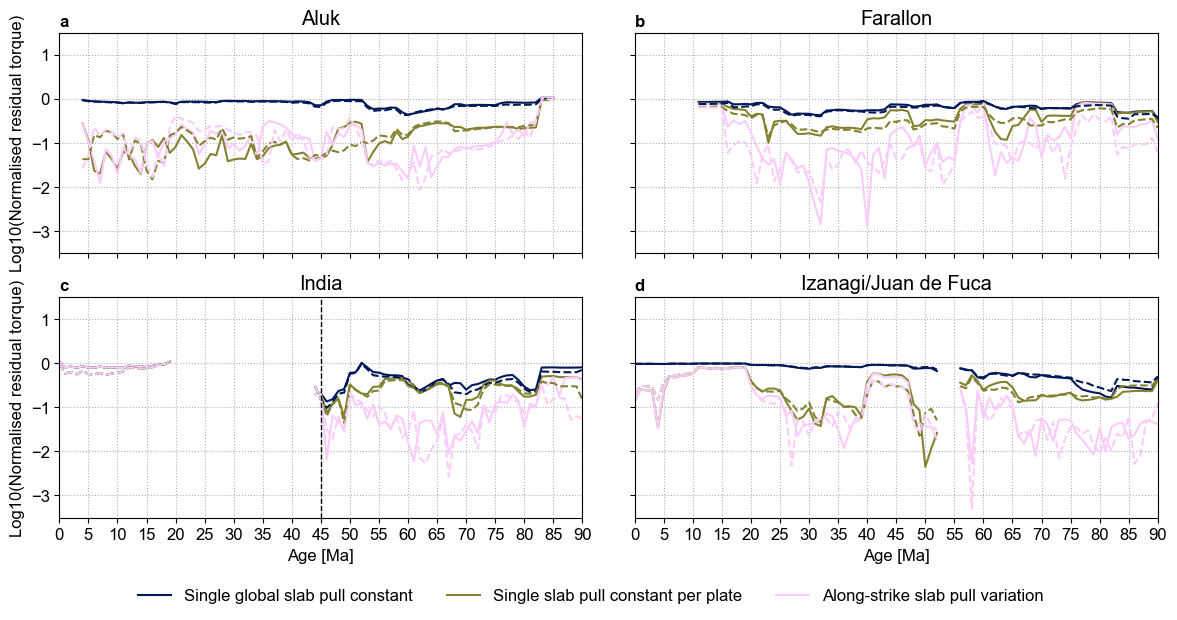

In [13]:
# Create a figure and gridspec
fig = plt.figure(figsize=(fig_width, fig_height_graphs))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.1, hspace=0.2)

plot_plateIDs = [904, 902, 501, 926]
plot_plate_names = ["Aluk", "Farallon", "India", "Izanagi/Juan de Fuca"]

optimisation_colours = plt.get_cmap("cmc.batlow")(np.linspace(0, 1, 3))
optimisation_labels = ["Single global slab pull constant", "Single slab pull constant per plate", "Along-strike slab pull variation"]

# Plot the residual torques
m = 0
for i in range(2):
    for j in range(2):
        ax = plt.subplot(gs[i, j])
        ax.set_title(f"{plot_plate_names[m]}")
        for k, case in enumerate(["ref", "opt1", "opt2"]):
            ax.plot(
                residual_torque[case]["Age"],
                np.log10(residual_torque[case][plot_plateIDs[m]]/driving_torque[case][plot_plateIDs[m]]),
                c = optimisation_colours[k],
                label = optimisation_labels[k],
            )
            if plot_plateIDs[m] == 926:
                ax.plot(
                    residual_torque[case]["Age"],
                    np.log10(residual_torque[case][903]/driving_torque[case][903]),
                    c = optimisation_colours[k],
                )

        for k, case in enumerate(["ref_nnr", "opt1_nnr", "opt2_nnr"]):
            ax.plot(
                residual_torque[case]["Age"],
                np.log10(residual_torque[case][plot_plateIDs[m]]/driving_torque[case][plot_plateIDs[m]]),
                c = optimisation_colours[k],
                ls = "--",
            )
            if plot_plateIDs[m] == 926:
                ax.plot(
                    residual_torque[case]["Age"],
                    np.log10(residual_torque[case][903]/driving_torque[case][903]),
                    c = optimisation_colours[k],
                    ls = "--",
                )
        
        if plot_plateIDs[m] == 501:
            ax.vlines(45, -3.5, 1.5, color="k", ls="--", lw=1)

        ax.grid(ls=":")
        
        ax.set_xlim(residual_torque[case]["Age"].min(), residual_torque[case]["Age"].max())
        ax.set_ylim(-3.5, 1.5)

        ax.set_xticks(np.arange(residual_torque[case]["Age"].min(), residual_torque[case]["Age"].max()+1, 5))

        ax.set_xticklabels([]) if i == 0 else None
        ax.set_yticklabels([]) if j == 1 else None

        ax.set_xlabel("Age [Ma]") if i == 1 else None
        ax.set_ylabel("Log10(Normalised residual torque)") if j == 0 else None

        ax.annotate(annotations[m], xy=(0, 1.03), xycoords="axes fraction", fontweight="bold")

        m += 1

# Add a legend below the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.05))

fig.savefig(os.path.join(figs_dir, "M2016_optimised_residual_torques_1.png"), bbox_inches="tight", dpi=300)

plt.show()

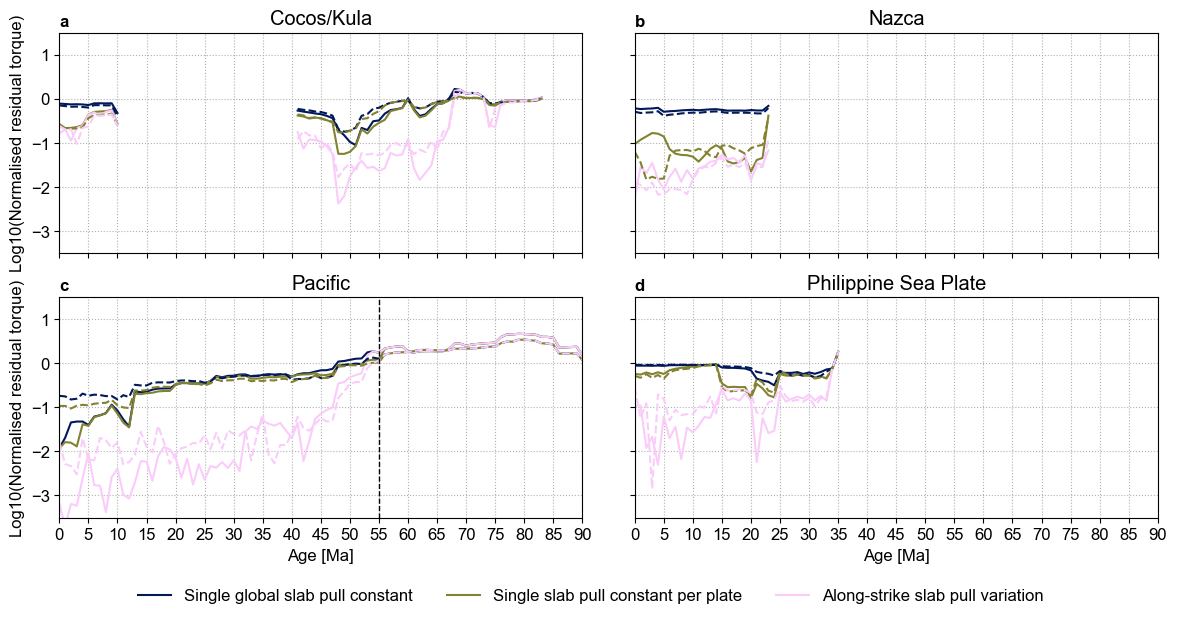

In [14]:
# Create a figure and gridspec
fig = plt.figure(figsize=(fig_width, fig_height_graphs))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.1, hspace=0.2)

plot_plateIDs = [909, 911, 901, 608]
plot_plate_names = ["Cocos/Kula", "Nazca", "Pacific", "Philippine Sea Plate"]

optimisation_colours = plt.get_cmap("cmc.batlow")(np.linspace(0, 1, 3))
optimisation_labels = ["Single global slab pull constant", "Single slab pull constant per plate", "Along-strike slab pull variation"]

# Plot the residual torques
m = 0
for i in range(2):
    for j in range(2):
        ax = plt.subplot(gs[i, j])
        ax.set_title(f"{plot_plate_names[m]}")
        for k, case in enumerate(["ref", "opt1", "opt2"]):
            ax.plot(
                residual_torque[case]["Age"],
                np.log10(residual_torque[case][plot_plateIDs[m]]/driving_torque[case][plot_plateIDs[m]]),
                c = optimisation_colours[k],
                label = optimisation_labels[k],
            )
            if plot_plateIDs[m] == 909:
                ax.plot(
                    residual_torque[case]["Age"],
                    np.log10(residual_torque[case][918]/driving_torque[case][918]),
                    c = optimisation_colours[k],
                )

        for k, case in enumerate(["ref_nnr", "opt1_nnr", "opt2_nnr"]):
            ax.plot(
                residual_torque[case]["Age"],
                np.log10(residual_torque[case][plot_plateIDs[m]]/driving_torque[case][plot_plateIDs[m]]),
                c = optimisation_colours[k],
                ls = "--",
            )
            if plot_plateIDs[m] == 909:
                ax.plot(
                    residual_torque[case]["Age"],
                    np.log10(residual_torque[case][918]/driving_torque[case][918]),
                    c = optimisation_colours[k],
                    ls = "--",
                )
        
        if plot_plateIDs[m] == 901:
            ax.vlines(55, -3.5, 1.5, color="k", ls="--", lw=1)

        ax.grid(ls=":")
        
        ax.set_xlim(residual_torque[case]["Age"].min(), residual_torque[case]["Age"].max())
        ax.set_ylim(-3.5, 1.5)

        ax.set_xticks(np.arange(residual_torque[case]["Age"].min(), residual_torque[case]["Age"].max()+1, 5))

        ax.set_xticklabels([]) if i == 0 else None
        ax.set_yticklabels([]) if j == 1 else None

        ax.set_xlabel("Age [Ma]") if i == 1 else None
        ax.set_ylabel("Log10(Normalised residual torque)") if j == 0 else None

        ax.annotate(annotations[m], xy=(0, 1.03), xycoords="axes fraction", fontweight="bold")

        m += 1

# Add a legend below the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.05))

fig.savefig(os.path.join(figs_dir, "M2016_optimised_residual_torques_2.png"), bbox_inches="tight", dpi=300)

plt.show()

In [15]:
plot_M2016 = PlotReconstruction(M2016, coastline_file=os.path.join(data_dir, "gplates_files", "M2016_coastlines.gpml"))

In [16]:
if PLOT_FIGS:
    if TEST_RUN:
        plot_ages = [0, 60]
    else:
        plot_ages = [0, 30, 60, 90]

    for plot_age in plot_ages:
        # Create a figure and gridspec
        fig = plt.figure(figsize=(fig_width, fig_height_maps))
        gs = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.1)

        plot_cases = ["opt1", "opt2", "opt1_nnr", "opt2_nnr"]

        plot_titles = ["Simple optimisation", "Complex optimisation", "Simple optimisation (NNR)", "Complex optimisation (NNR)"]
        
        # Plot slab pull constant along trenches for each case
        m = 0
        for i in range(2):
            for j in range(2):
                ax = plt.subplot(gs[i, j], projection=projection)
                ax.set_title(f"{plot_titles[m]} - {plot_age} Ma", fontsize=title_fontsize)
                if plot_age < 36:
                    vel_diffs = plot_M2016.plot_velocity_difference_map(ax, plot_age, f"syn_{plot_cases[m]}", plot_cases[m], plateIDs = plateIDs + [608, 901], vmin=-5, vmax=5)
                elif plot_age < 46:
                    vel_diffs = plot_M2016.plot_velocity_difference_map(ax, plot_age, f"syn_{plot_cases[m]}", plot_cases[m], plateIDs = plateIDs + [901], vmin=-5, vmax=5)
                elif plot_age < 56:
                    vel_diffs = plot_M2016.plot_velocity_difference_map(ax, plot_age, f"syn_{plot_cases[m]}", plot_cases[m], plateIDs = plateIDs + [501, 901], vmin=-5, vmax=5)
                else:
                    vel_diffs = plot_M2016.plot_velocity_difference_map(ax, plot_age, f"syn_{plot_cases[m]}", plot_cases[m], plateIDs = plateIDs + [501], vmin=-5, vmax=5)

                ax.annotate(annotations[m], xy=(-0.053, 1.03), xycoords="axes fraction", fontweight="bold", fontsize=title_fontsize)
                
                m += 1

        # Create a new grid for the colourbar
        cax = fig.add_axes([0.362, 0.06, 0.3, 0.02])

        # Create a colourbar below the subplots
        cbar = plt.colorbar(vel_diffs[0], cax=cax, orientation="horizontal", extend="both", extendfrac=5e-2)

        # Set colourbar label
        cbar.set_label("Plate speed difference [cm/a]", labelpad=5)

        # Set colourbar ticks
        cbar.set_ticks(np.arange(-5, 6, 1))

        fig.savefig(os.path.join(figs_dir, f"M2016_velocity_field_difference_{plot_age}Ma.png"), bbox_inches="tight", dpi=300)

        plt.show()

In [17]:
if PLOT_FIGS:
    # Create a figure and gridspec
    fig = plt.figure(figsize=(fig_width, fig_height_maps))
    gs = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.1)

    plot_cases = ["opt1", "opt2", "opt1_nnr", "opt2_nnr"]

    plot_titles = ["Simple optimisation", "Complex optimisation", "Simple optimisation (NNR)", "Complex optimisation (NNR)"]

    # Plot slab pull constant along trenches for each case
    m = 0
    for i in range(2):
        for j in range(2):
            ax = plt.subplot(gs[i, j], projection=projection)
            plot_M2016.plot_basemap(ax)
            ax.coastlines(lw=0.5)
            ax.set_title(f"{plot_titles[m]} ({M2016.ages[0]}-{M2016.ages[-1]} Ma)", fontsize=title_fontsize)
            ax.set_global()
            for age in np.flip(M2016.ages):
                slab_data = M2016.slabs.data[age][plot_cases[m]]
                if age < 36:
                    slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs + [608, 901])]
                elif age < 46:
                    slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs + [901])]
                elif age < 56:
                    slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs + [501, 901])]
                else:
                    slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs + [501])]

                sc = ax.scatter(
                        slab_data.lon,
                        slab_data.lat,
                        c = slab_data.slab_pull_constant,
                        s = 2,
                        vmin = 0,
                        vmax = .9,
                        cmap = "cmc.nuuk",
                        transform = ccrs.PlateCarree(),
                        # alpha=.5,
                    )
                
                ax.annotate(annotations[m], xy=(-0.053, 1.03), xycoords="axes fraction", fontweight="bold", fontsize=title_fontsize)
                
            m += 1

    # Create a new grid for the colorbar
    cax = fig.add_axes([0.362, 0.06, 0.3, 0.02])

    # Create a colorbar below the subplots
    cbar = plt.colorbar(sc, cax=cax, orientation="horizontal")

    # Set colourbar label
    cbar.set_label("Slab pull coefficient", labelpad=5)

    # Set colourbar ticks
    cbar.set_ticks(np.arange(0, 1, 0.1))

    fig.savefig(os.path.join(figs_dir, f"M2016_optimised_slab_pull_coefficient_distribution.png"), bbox_inches="tight", dpi=300)


In [18]:
# Select cases of interest
cases = ["opt1", "opt2", "opt1_nnr", "opt2_nnr"]

# Select regions of interest and their conditions
regions = ["NW", "NE", "SW", "SE"]
conditions = {"NW": "lon > 0 and lat > 0", "NE": "lon < 0 and lat > 0", "SW": "lon > 0 and lat < 0", "SE": "lon < 0 and lat < 0"}

# Initialise dictionaries to store all data
all_sp_consts = {case: [] for case in cases}
all_trench_lengths = {case: [] for case in cases}
all_lats = {case: [] for case in cases}
all_lons = {case: [] for case in cases}
all_slab_ages = {case: [] for case in cases}
all_slab_fluxes = {case: [] for case in cases}

# Initialise dictionaries to store data for each specific subregion
sp_consts_regions = {age: {case: {region: [] for region in regions} for case in cases} for age in M2016.ages}
trench_lengths_regions = {age: {case: {region: [] for region in regions} for case in cases} for age in M2016.ages}
slab_flux_regions = {age: {case: {region: [] for region in regions} for case in cases} for age in M2016.ages}
lat_regions = {age: {case: {region: [] for region in regions} for case in cases} for age in M2016.ages}
lon_regions = {age: {case: {region: [] for region in regions} for case in cases} for age in M2016.ages}
slab_ages_regions = {age: {case: {region: [] for region in regions} for case in cases} for age in M2016.ages}

# Loop through cases
for case in ["opt1", "opt2", "opt1_nnr", "opt2_nnr"]:
    # Loop through ages:
    for age in M2016.ages:
        # Select data
        slab_data = M2016.slabs.data[age][case]

        # Filter data by plateID
        if age < 36:
            slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs + [608, 901])]
        elif age < 46:
            slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs + [901])]
        elif age < 56:
            slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs + [901])]
        else:
            slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs)]

        # Store all data
        all_sp_consts[case].extend(np.nan_to_num(slab_data.slab_pull_constant.values))
        all_trench_lengths[case].extend(np.nan_to_num(slab_data.trench_segment_length.values))
        all_lats[case].extend(np.nan_to_num(slab_data.lat.values))
        all_lons[case].extend(np.nan_to_num(slab_data.lon.values))
        all_slab_ages[case].extend(np.nan_to_num(slab_data.slab_seafloor_age.values))
        all_slab_fluxes[case].extend(np.nan_to_num((slab_data.slab_lithospheric_thickness + slab_data.slab_crustal_thickness) * slab_data.convergence_velocity_mag * slab_data.trench_segment_length))

        # Loop through regions:
        for region, condition in conditions.items():
            sp_consts_regions[age][case][region].extend(np.nan_to_num(slab_data.query(condition).slab_pull_constant.values))
            trench_lengths_regions[age][case][region].extend(np.nan_to_num(slab_data.query(condition).trench_segment_length.values))
            lat_regions[age][case][region].extend(np.nan_to_num(slab_data.query(condition).lat.values))
            lon_regions[age][case][region].extend(np.nan_to_num(slab_data.query(condition).lon.values))
            slab_ages_regions[age][case][region].extend(np.nan_to_num(slab_data.query(condition).slab_seafloor_age.values))

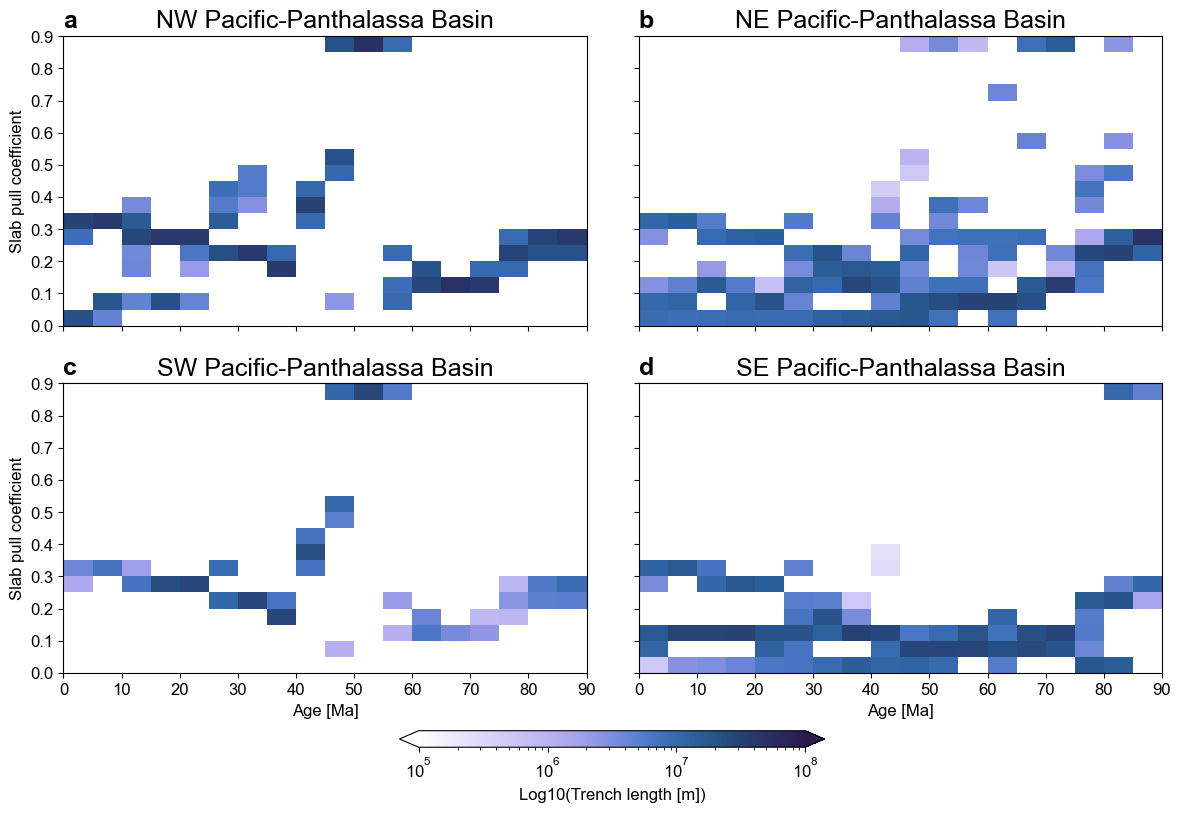

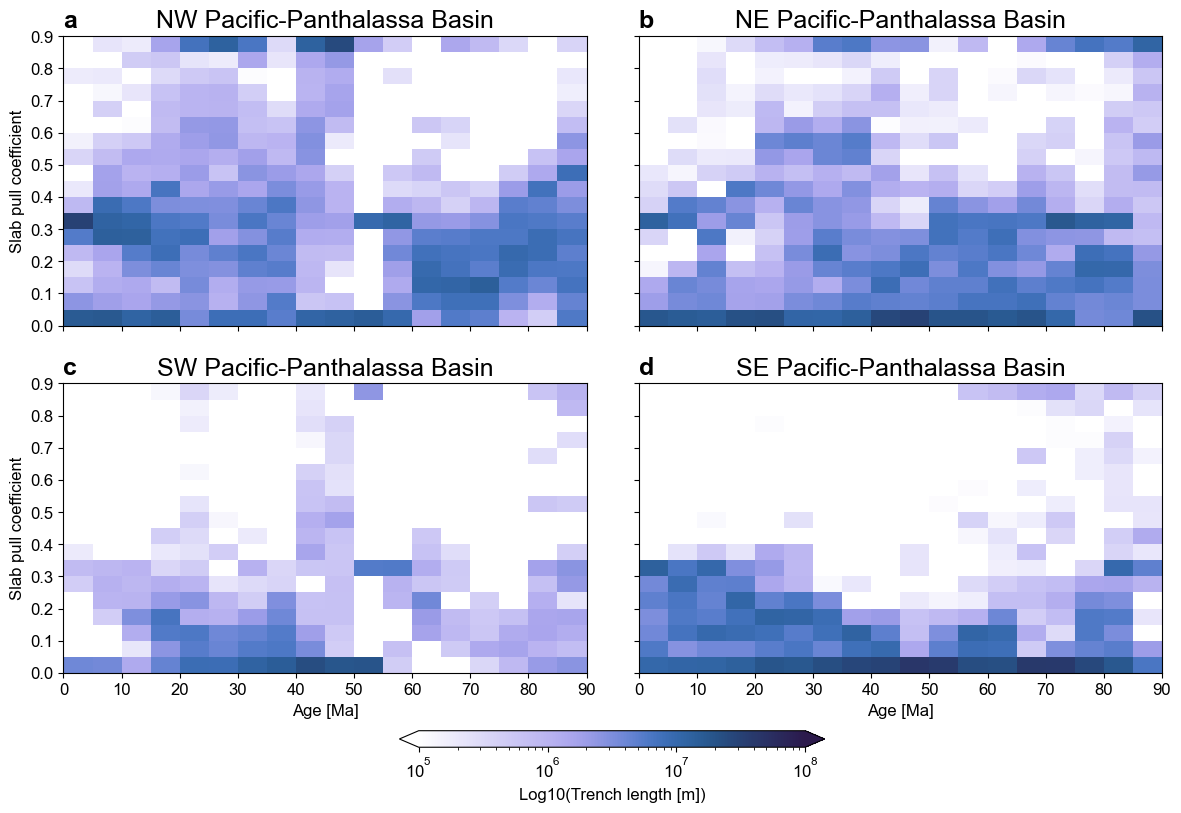

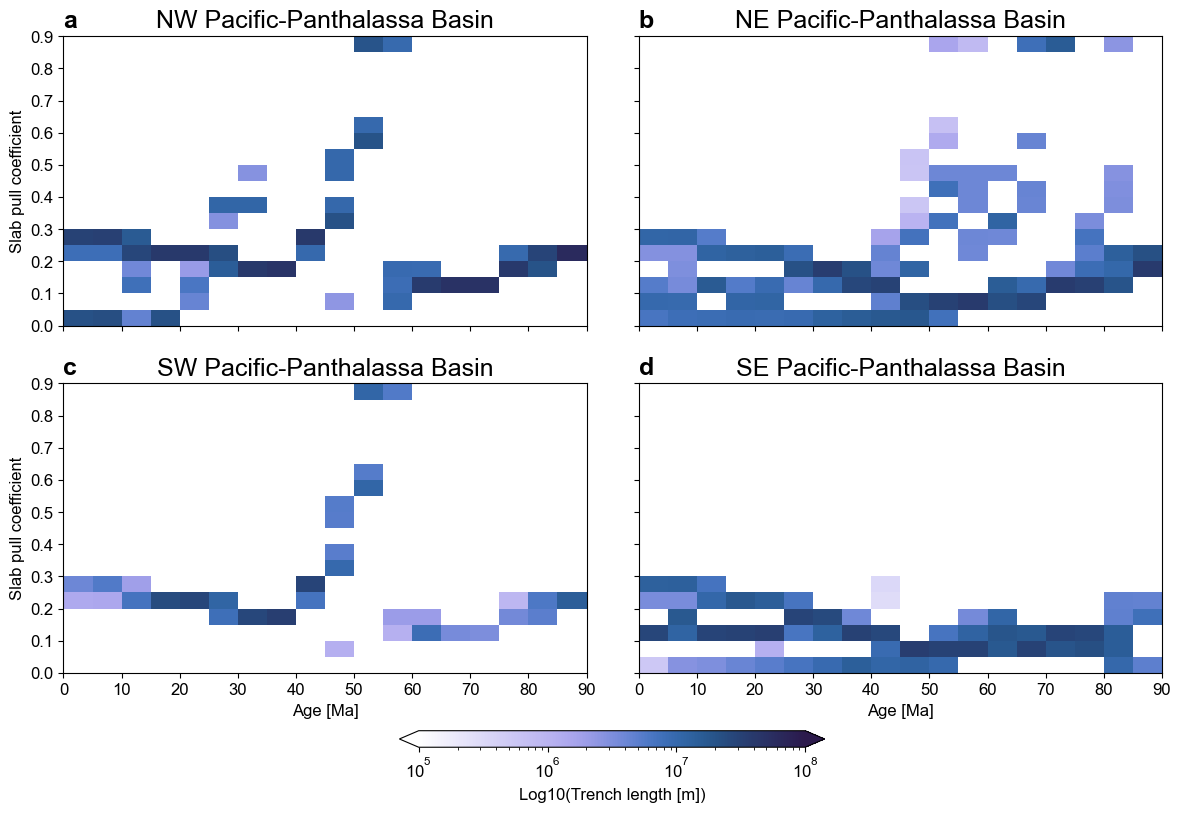

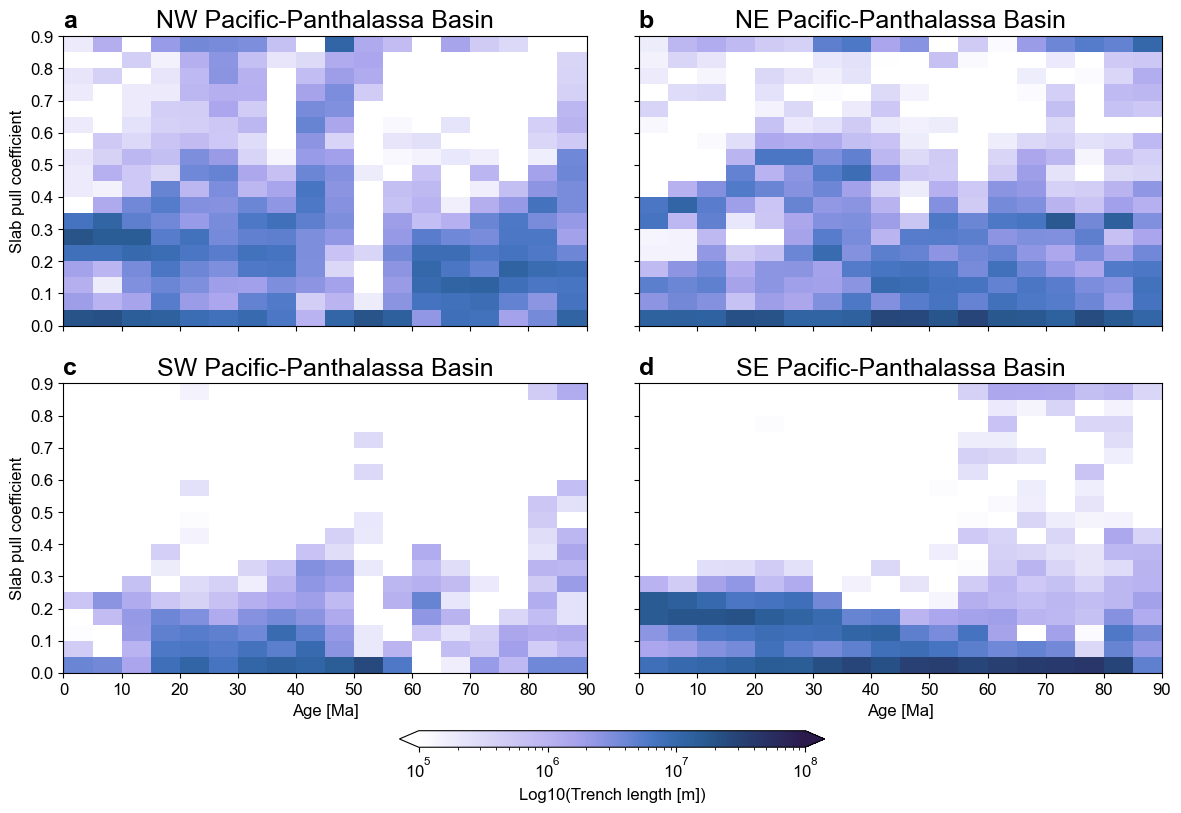

In [19]:
for case in cases:
    # Create a figure and gridspec
    fig = plt.figure(figsize=(fig_width, fig_height_maps))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.1, hspace=0.2)

    m = 0
    for i in range(2):
        for j in range(2):
            ax = plt.subplot(gs[i, j])
            ax.set_title(f"{regions[m]} Pacific-Panthalassa Basin", fontsize=title_fontsize)

            # Collect all data points for this region
            ages = []
            values = []
            weights = []
            for age in M2016.ages:
                ages.extend([age] * len(sp_consts_regions[age][case][regions[m]]))  # Repeat age for each value
                values.extend(sp_consts_regions[age][case][regions[m]])  # Slab pull constant values
                weights.extend(trench_lengths_regions[age][case][regions[m]])  # Corresponding trench segment lengths

            # Convert to numpy arrays
            ages = np.array(ages)
            values = np.array(values)
            weights = np.array(weights)

            # Plot using hist2d (2D histogram), weighted by trench segment length
            h = ax.hist2d(ages, values, bins=[18, 18], cmap="cmc.devon_r", range=[[0, 90], [0, .9]], 
                weights=weights, norm=mcolors.LogNorm(vmin=1e5, vmax=1e8))

            ax.set_ylim(0, .9)
            ax.set_xlim(0, 90)

            ax.set_xticks(np.arange(0, 91, 10))
            ax.set_yticks(np.arange(0, 1, 0.1))

            ax.set_xticklabels([]) if i == 0 else None
            ax.set_yticklabels([]) if j == 1 else None

            ax.set_xlabel("Age [Ma]") if i == 1 else None
            ax.set_ylabel("Slab pull coefficient") if j == 0 else None

            ax.annotate(annotations[m], xy=(0, 1.03), xycoords="axes fraction", fontweight="bold", fontsize=title_fontsize)        

            m += 1

    # Create a new grid for the colorbar
    cax = fig.add_axes([0.362, 0.02, 0.3, 0.02])

    # Create a colorbar below the subplots
    cbar = plt.colorbar(h[3], cax=cax, orientation="horizontal", extend="both")

    # Set colorbar label
    cbar.set_label("Log10(Trench length [m])", labelpad=5)

    # Save figure
    fig.savefig(os.path.join(figs_dir, f"M2016_slab_pull_coefficient_vs_time_{case}.png"), bbox_inches="tight", dpi=300)

    # Show figure
    plt.show()

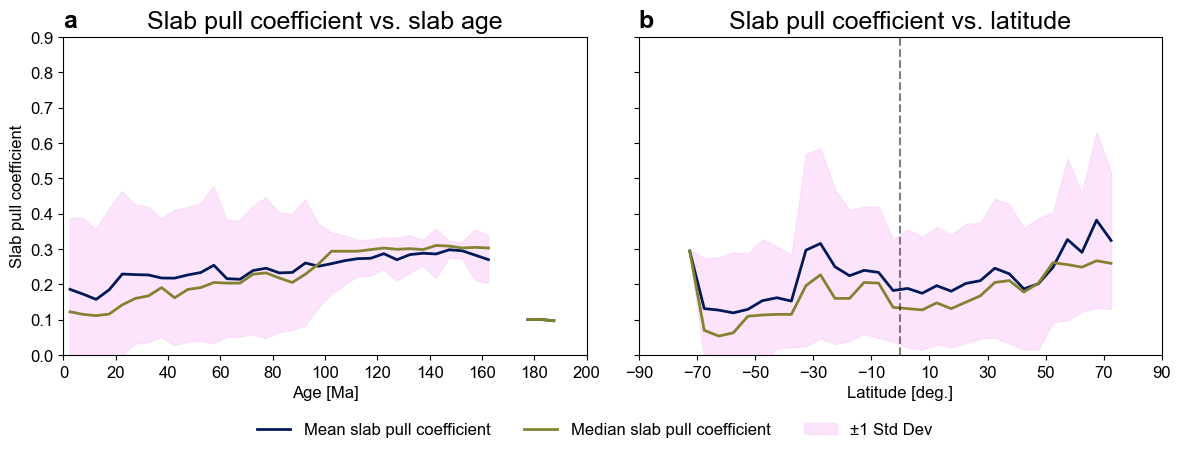

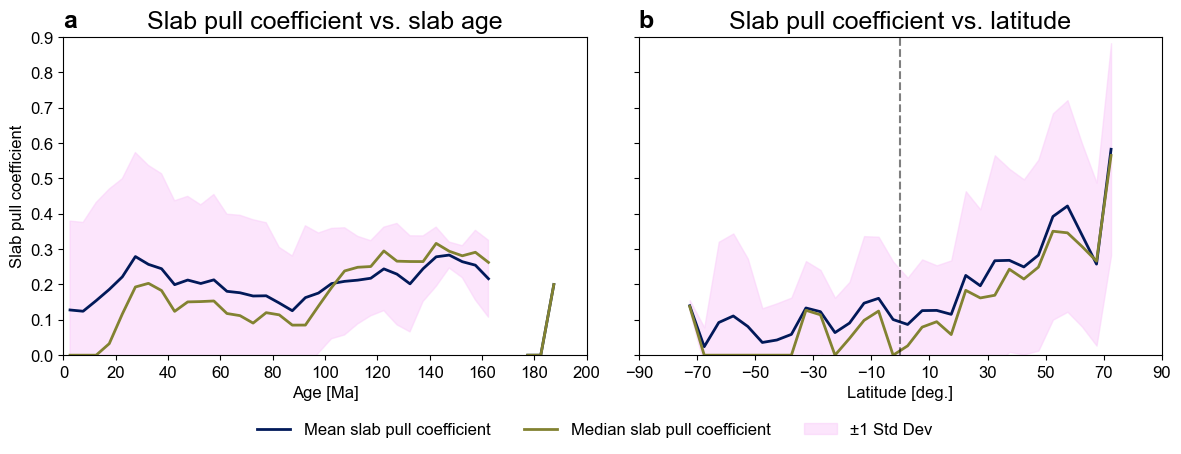

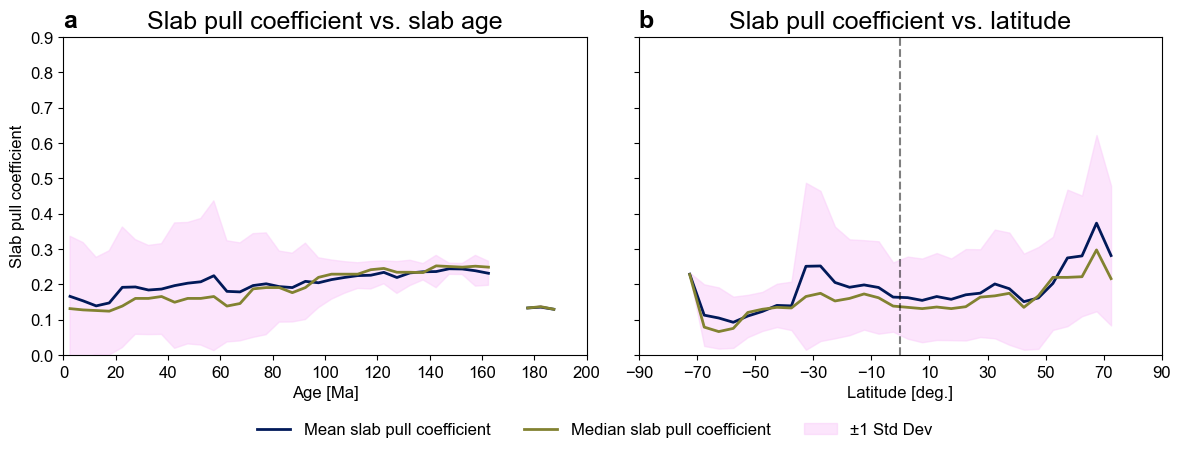

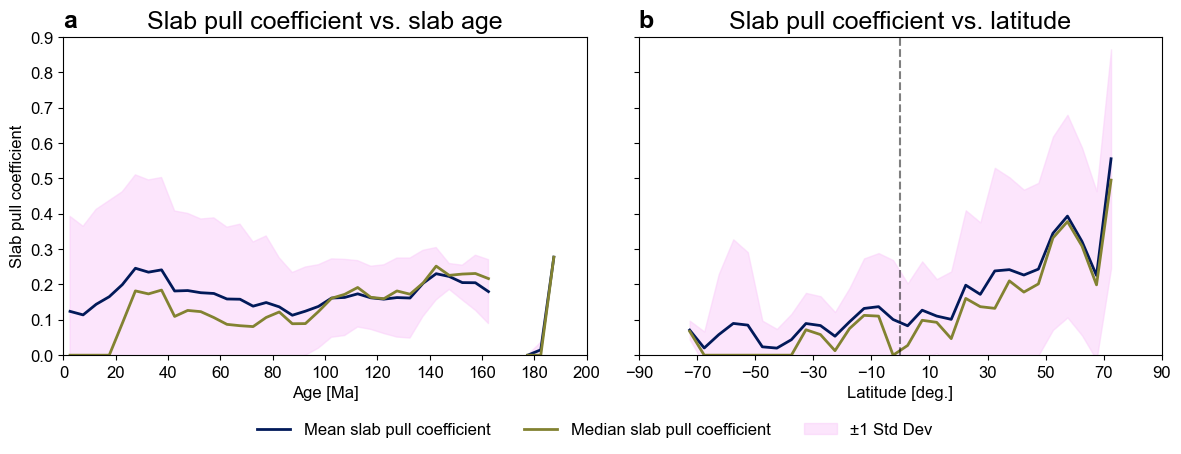

In [20]:
# Define age bins
age_bins = np.arange(0, 205, 5)  # Bins go slightly beyond 200 to include the last edge
age_centers = (age_bins[:-1] + age_bins[1:]) / 2  # Compute bin centers

# Define latitude bins (e.g., every 5° from -90° to 90°)
lat_bins = np.arange(-90, 95, 5)  # Bins go slightly beyond 90 to include the last edge
lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2  # Compute bin centers

for case in cases:
    # Digitize ages to find which bin they belong to
    age_indices = np.digitize(all_slab_ages[case], age_bins) - 1  # Get bin indices

    # Digitize latitudes to find which bin they belong to
    lat_indices = np.digitize(all_lats[case], lat_bins) - 1  # Get bin indices

    # Initialise arrays to store mean and std dev
    mean_sp_consts = {}; median_sp_consts = {}; std_sp_consts = {}
    for var, centres in zip(["age", "lat"], [age_centers, lat_centers]):
        mean_sp_consts[var] = np.full(len(centres), np.nan)
        median_sp_consts[var] = np.full(len(centres), np.nan)
        std_sp_consts[var] = np.full(len(centres), np.nan)

    # Compute mean and std dev for each latitude bin
    for var, centres, indices in zip(["age", "lat"], [age_centers, lat_centers], [age_indices, lat_indices]):
        for i in range(len(centres)):
            bin_mask = indices == i
            if np.any(bin_mask):  # If there are values in the bin
                mean_sp_consts[var][i] = np.mean(np.array(all_sp_consts[case])[bin_mask])
                median_sp_consts[var][i] = np.median(np.array(all_sp_consts[case])[bin_mask])
                std_sp_consts[var][i] = np.std(np.array(all_sp_consts[case])[bin_mask])

    # Create a figure and gridspec
    fig = plt.figure(figsize=(fig_width, fig_height_maps/2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

    for i, (var, centres) in enumerate(zip(["age", "lat"], [age_centers, lat_centers])):
        ax = plt.subplot(gs[i])
        ax.plot(centres, mean_sp_consts[var], label="Mean slab pull coefficient", color=optimisation_colours[0], linewidth=2)
        ax.plot(centres, median_sp_consts[var], label="Median slab pull coefficient", color=optimisation_colours[1], linewidth=2)
        ax.fill_between(centres, mean_sp_consts[var] - std_sp_consts[var], mean_sp_consts[var] + std_sp_consts[var], 
                        color=optimisation_colours[-1], alpha=0.5, label="±1 Std Dev")
        
        # Labels and limits
        ax.set_ylabel("Slab pull coefficient") if i == 0 else None
        ax.set_xlabel("Latitude [deg.]") if i == 1 else ax.set_xlabel("Age [Ma]")
        ax.set_xticks(np.arange(0, 201, 20)) if i == 0 else ax.set_xticks(np.arange(-90, 91, 20))
        ax.set_yticklabels([]) if i == 1 else None
        ax.set_ylim(0, .9)
        ax.set_xlim(0, 200) if i == 0 else ax.set_xlim(-90, 90)
        ax.set_title(f"Slab pull coefficient vs. latitude", fontsize=title_fontsize) if i == 1 else ax.set_title(f"Slab pull coefficient vs. slab age", fontsize=title_fontsize)
        ax.annotate(annotations[i], xy=(0, 1.03), xycoords="axes fraction", fontweight="bold", fontsize=title_fontsize)

        # Reference lines
        if var == "lat":
            ax.axvline(0, linestyle="--", color="k", alpha=0.5)

    # Add a legend below the entire figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.125))

    fig.savefig(os.path.join(figs_dir, f"Slab_pull_coefficent_vs_age_latitude_{case}.png"), bbox_inches="tight", dpi=300)